In [1]:
import os
import math
import numpy as np
import pandas as pd
from ast import literal_eval
from scipy.special import kl_div
import pymc3
import itertools
import arviz as az
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
pd.options.mode.chained_assignment = None  # default='warn'

from helper_functions import pre_process_input_data, pre_process_eye_data, point_estimate, pixel_to_degree, calc_saccade_direction_adjusted

In [2]:
root_dir = os.getcwd()

data_dir = "/experimental_data/"

target_string = "output"
target_string_eye_tracking = "eye_tracking"
done_string = "done"

successfull_runs = []

for subdir, dirs, files in os.walk(root_dir+data_dir):
    for file in files:
        if done_string in file:
            successfull_runs.append(file)

## Picking exemplary data

In [3]:
successfull_runs[0]

'OK01UE_output_5FN_done_10.csv'

In [4]:
code = successfull_runs[0][:6]
triplet = successfull_runs[0][14:17]
run = successfull_runs[0][23:25]

file_name = f'{code}_eye_tracking_output_{triplet}_{run}.csv'

data = pre_process_eye_data(pd.read_csv((f"{root_dir + data_dir}{code}/eye_data/{file_name}"), index_col=False))
data

,time_tag,TimeTag,LeftEyeX,LeftEyeY,LeftPupilDiameter,RightEyeX,RightEyeY,RightPupilDiameter,DigitalIn,LeftBlink,...,distance_to_spaceship_in_pixel,distance_to_spaceship,exploring_fixation,Saccade,saccadeOnset,N_saccade,saccade_direction_x,saccade_direction_y,saccade_amplitude_in_pixel,saccade_amplitude
0,0.0000,5011.7430,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN
1,0.0005,5011.7435,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN
2,0.0010,5011.7440,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN
3,0.0015,5011.7445,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN
4,0.0020,5011.7450,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58762,29.3810,5041.1240,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN
58763,29.3815,5041.1245,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN
58764,29.3820,5041.1250,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN
58765,29.3825,5041.1255,NaN,NaN,9999.0,NaN,NaN,9999.0,16777215.0,1.0,...,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,NaN


In [5]:
data.columns

Index(['time_tag', 'TimeTag', 'LeftEyeX', 'LeftEyeY', 'LeftPupilDiameter',
       'RightEyeX', 'RightEyeY', 'RightPupilDiameter', 'DigitalIn',
       'LeftBlink', 'RightBlink', 'DigitalOut', 'LeftEyeFixationFlag',
       'RightEyeFixationFlag', 'LeftEyeSaccadeFlag', 'RightEyeSaccadeFlag',
       'MessageCode', 'LeftEyeRawX', 'LeftEyeRawY', 'RightEyeRawX',
       'RightEyeRawY', 'Fixation', 'fixationOnset', 'N_fixation',
       'fixation_duration', 'converging_eye_x', 'converging_eye_y',
       'converging_eye_x_adjusted', 'converging_eye_y_adjusted',
       'distance_to_spaceship_in_pixel', 'distance_to_spaceship',
       'exploring_fixation', 'Saccade', 'saccadeOnset', 'N_saccade',
       'saccade_direction_x', 'saccade_direction_y',
       'saccade_amplitude_in_pixel', 'saccade_amplitude'],
      dtype='object')

# Identifying action goals

We hypothesize that action goals are strongly linked to visual attention. Therefore when the visual attention stays at the same relative position within the instance, this might be the action goal - the position where the spaceship is actively steered towards.

Oculomotor control however combined top-down (action goal) and bottom-up (stimulus driven) processes. We have to identify action goals even when the eyes move somewhere else. Important is, that the eyes fixated on the action goal initially and the spaceship got closer and closer over time.

Action goals might therefore be accompanied by a progressive (downwards) saccade and a short period of smooth pursuit (fixation at relative position) converging with the spaceship.

In [86]:
# code below

Now we have the lines in which the saccade landed. We want to identify smooth pursuits after these saccades. Smooth pursuits should usually be marked as fixations. The slow travel of the eyes during these frames is still below the threshold and therefore they are flagged as Fixation==1 by the TRACKPixx algorithm. Consecutively, we will split the data into chunks from the saccadeland until another saccade is initiated. We will further explore the movement in the eyes within those chunks.

only NaNs in array
only NaNs in array
only NaNs in array
only NaNs in array
only NaNs in array
only NaNs in array


/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1295/2334361049.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12, 6))
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1295/2334361049.py:60: RuntimeWarning: Mean of empty slice
  mean_y_velocities.append(np.nanmean(steps_y))
/Users/heinrich/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


only NaNs in array
only NaNs in array
only NaNs in array
only NaNs in array
only NaNs in array


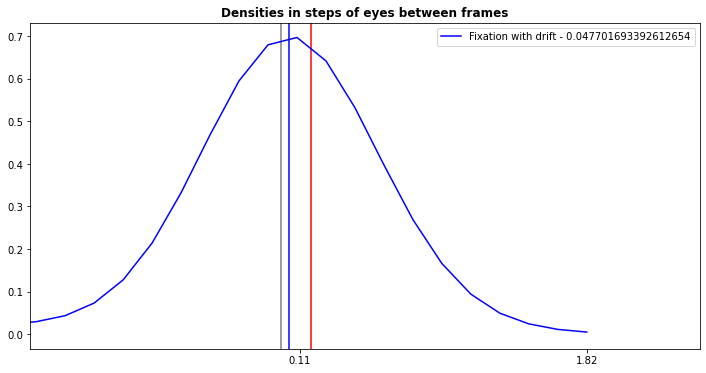

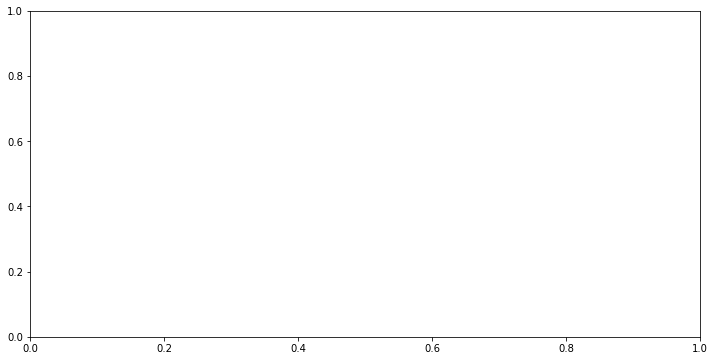

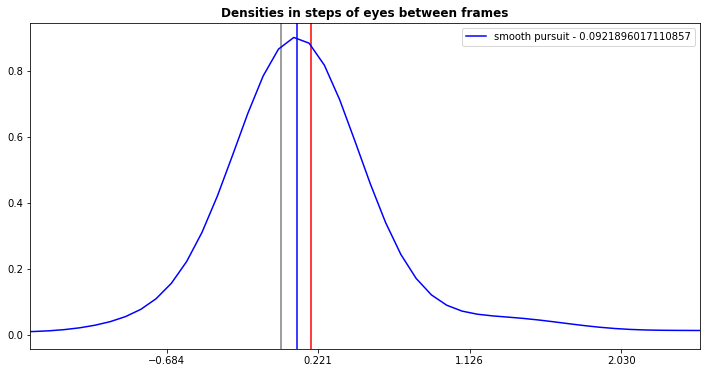

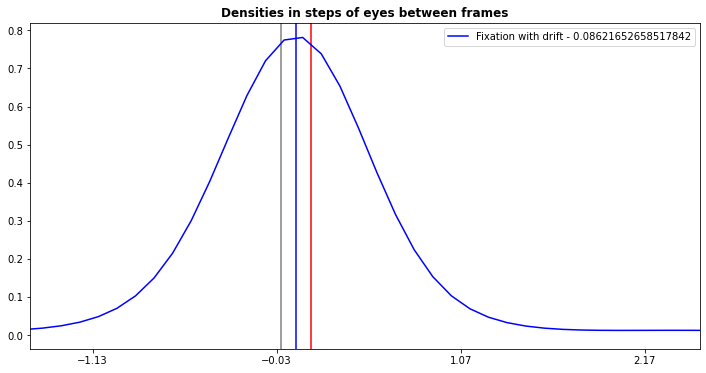

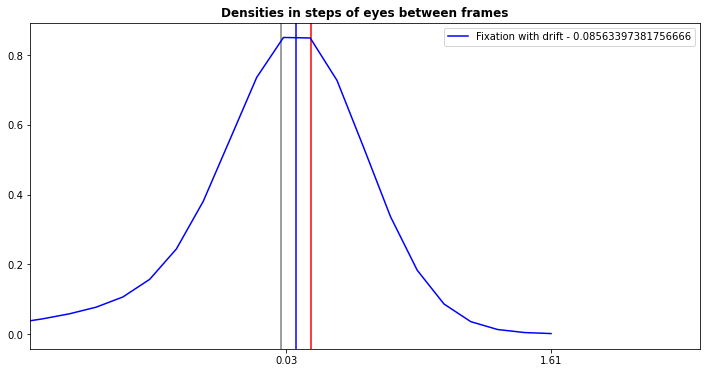

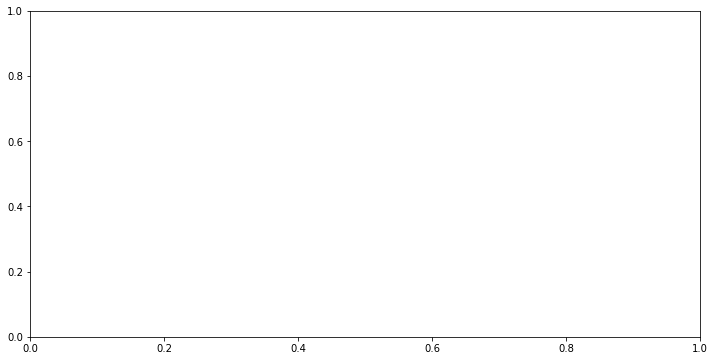

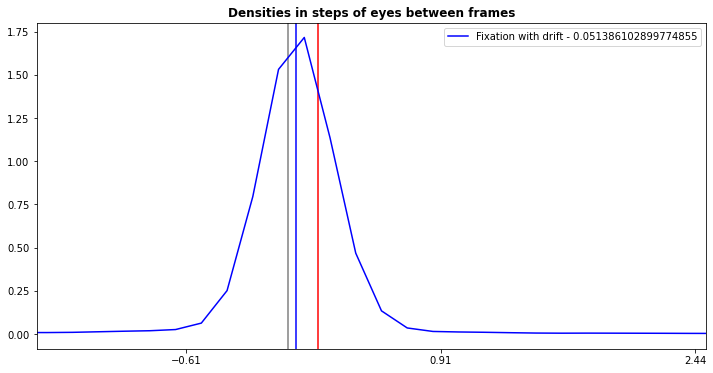

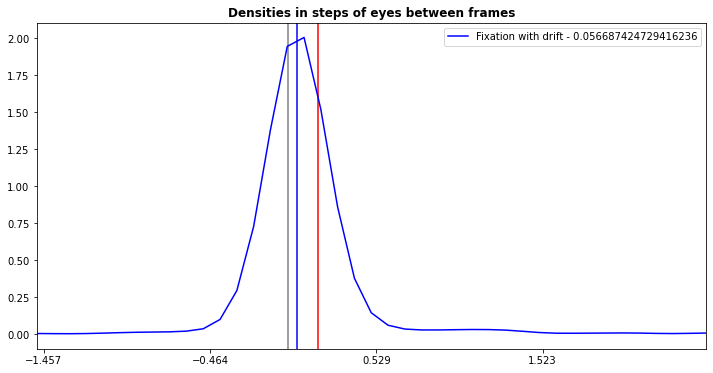

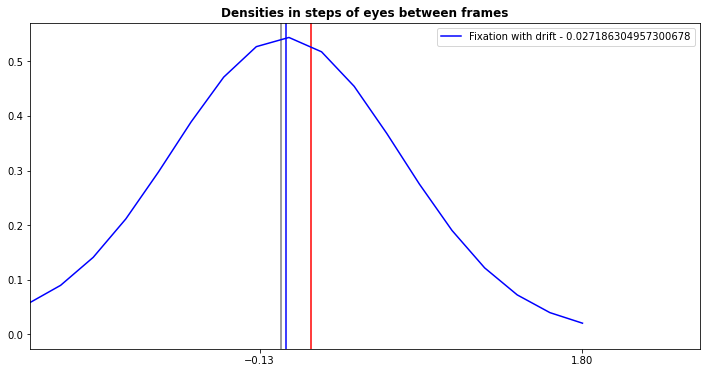

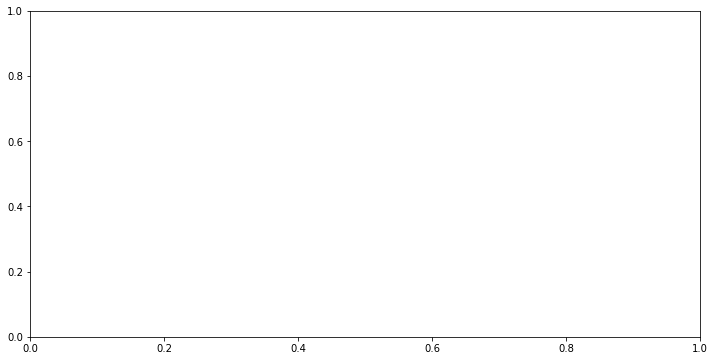

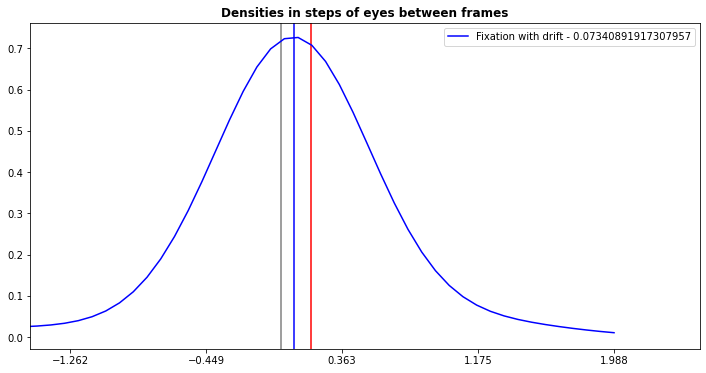

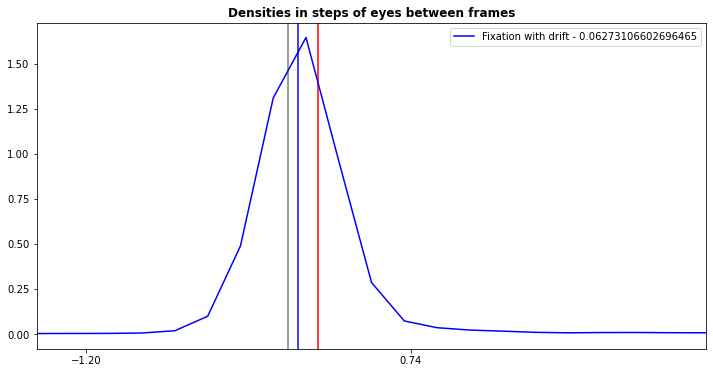

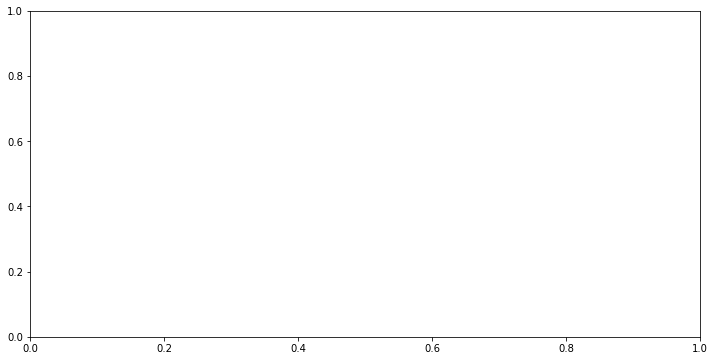

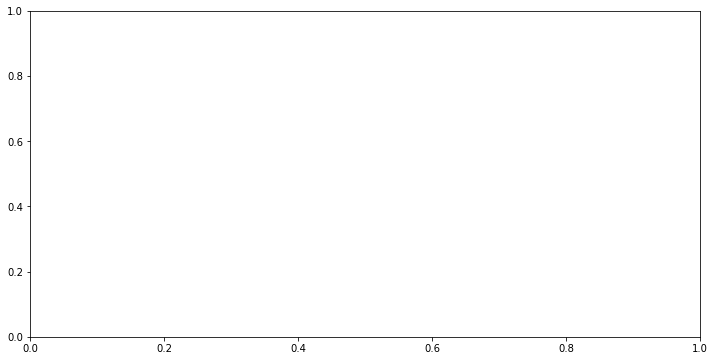

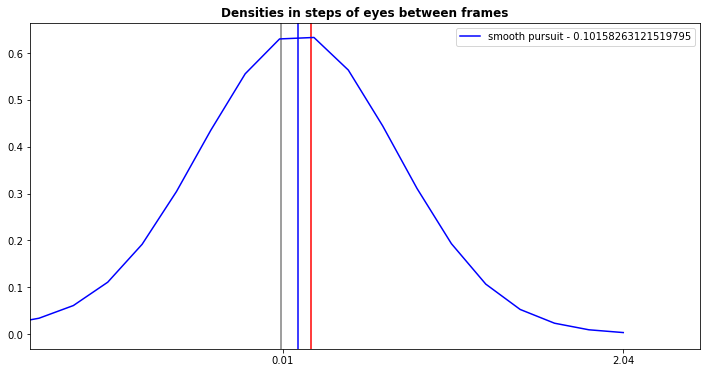

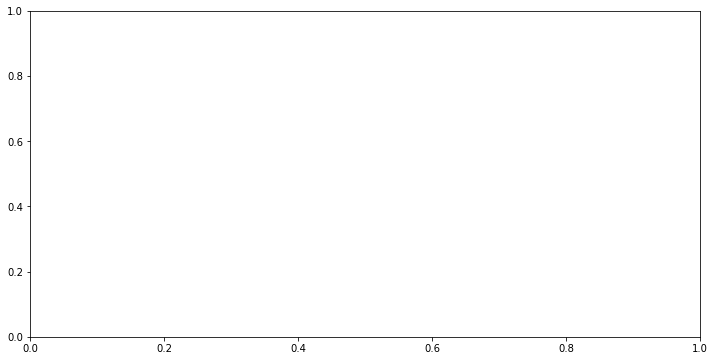

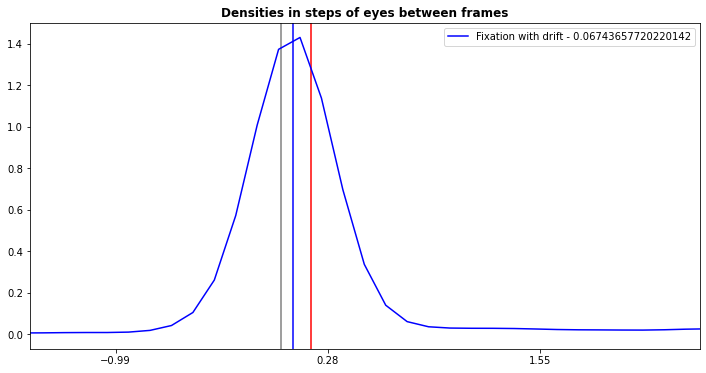

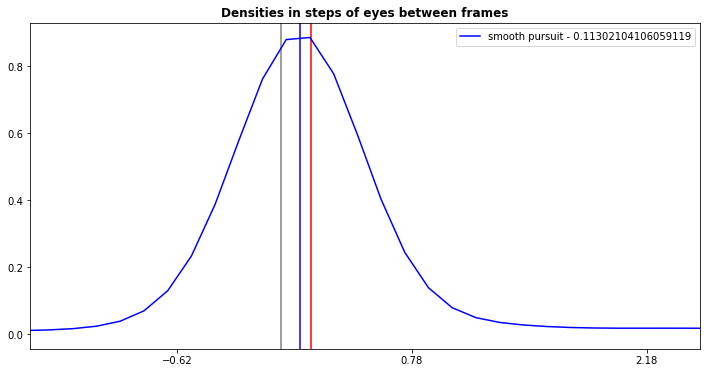

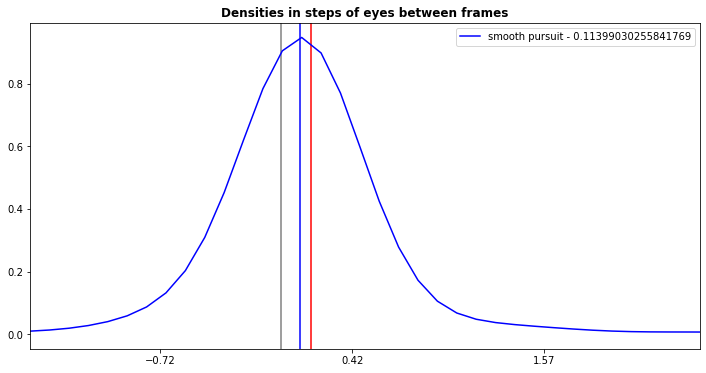

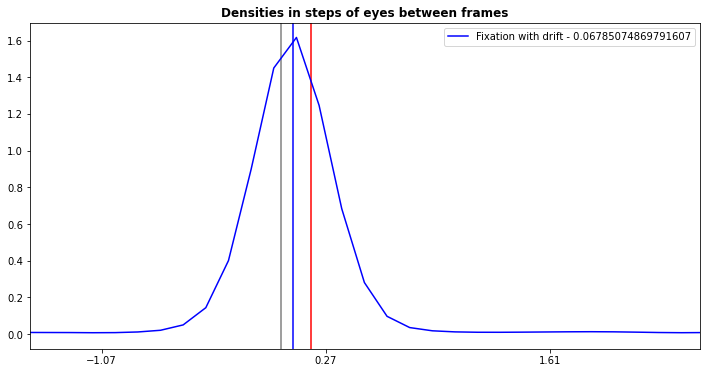

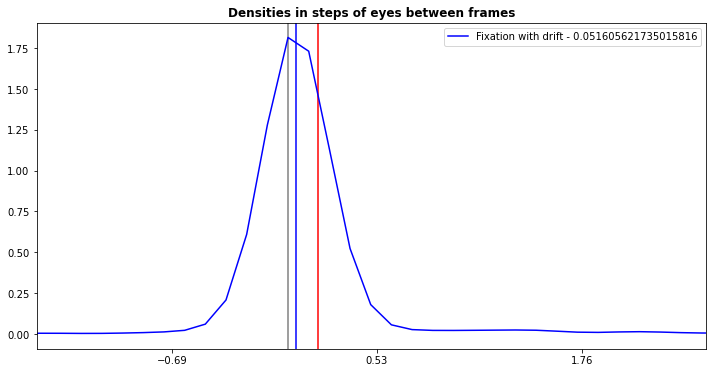

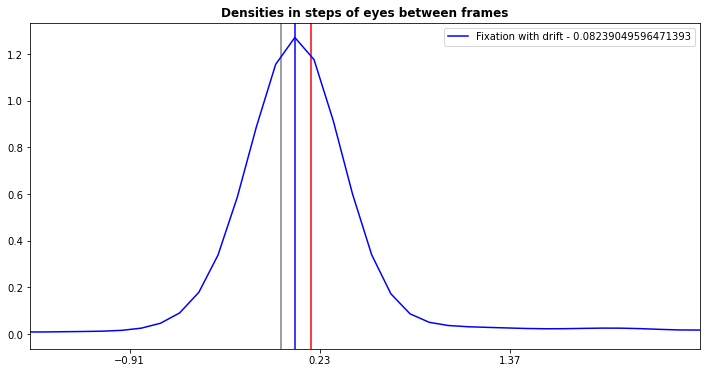

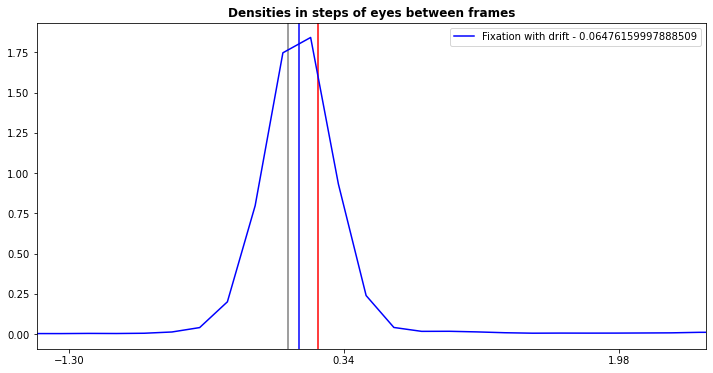

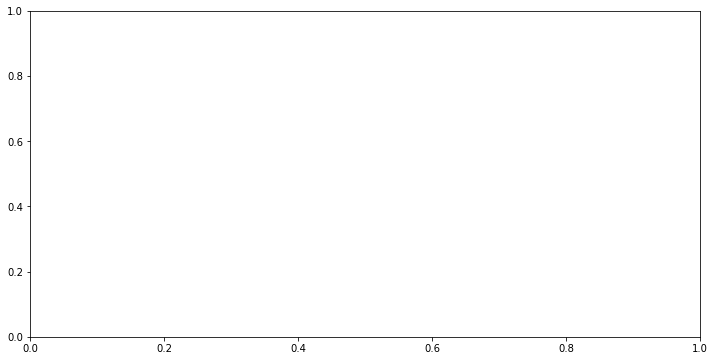

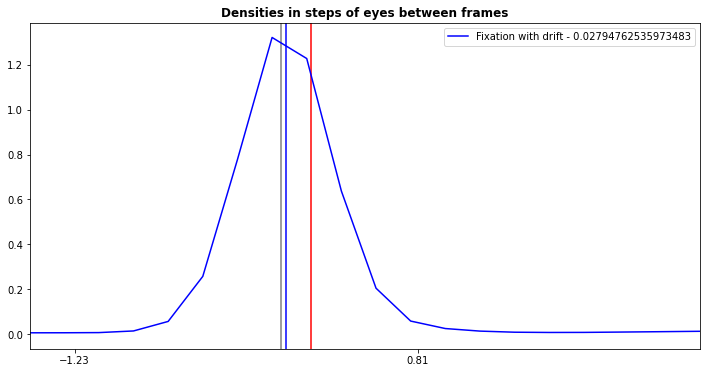

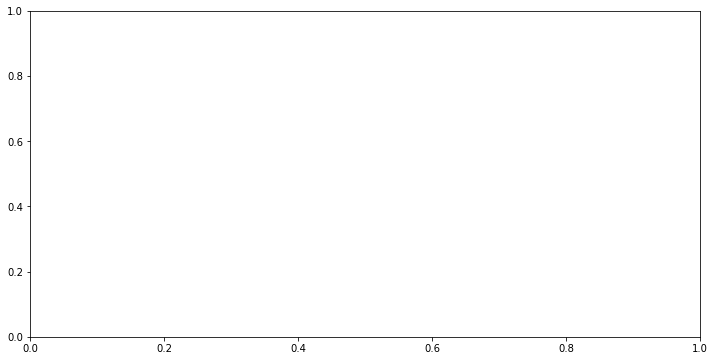

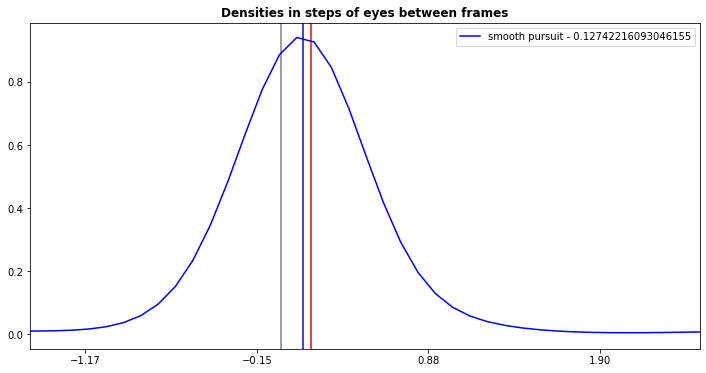

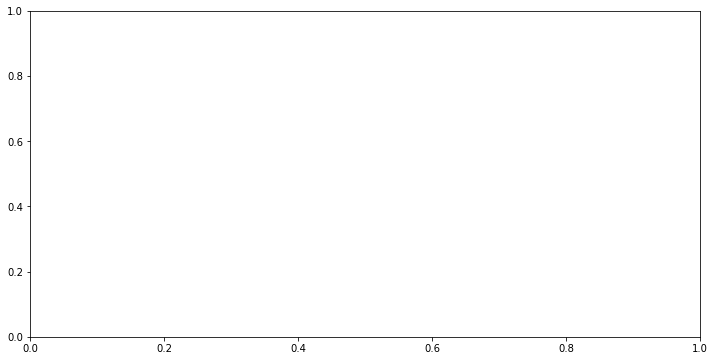

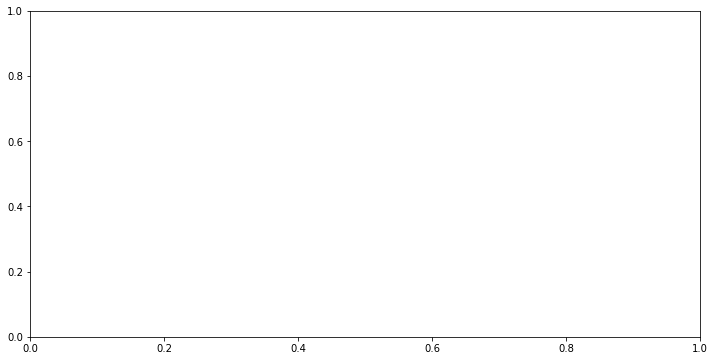

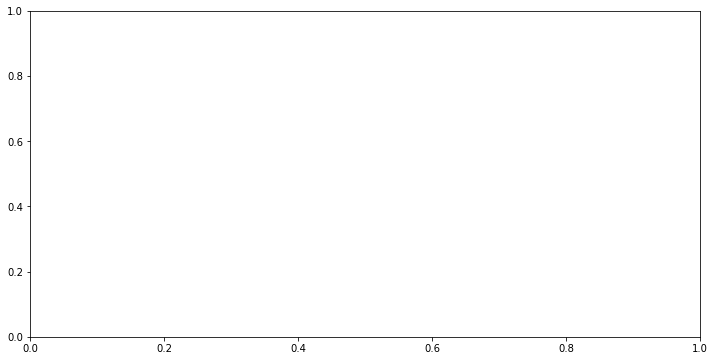

In [8]:
mean_y_velocities = []
sd_y_velocities = []

for row_id, row in sacclands.iterrows():
    index = row_id+1
    # cut off all data in front
    tail = data.iloc[index+1:]
    # identify end index
    try:        
        # when a saccade is initiated, that's when our chunk is sliced off
        end_index = tail[(tail.Saccade == 1)].index[0]
        sliced_data = data.iloc[index:end_index]
    except IndexError:
        # else until the end because we will apply nanmean therefore do not fear having all nans of the end in the chunk
        sliced_data = data.iloc[index:]
    
    steps_y = [i-j for i, j in zip(sliced_data.converging_eye_y_adjusted[:-1], sliced_data.converging_eye_y_adjusted[1:])]    
    
    # plot KDE of steps_y
    try:
        # Grid
        fig, ax = plt.subplots(figsize=(12, 6))

        lbound = min(steps_y) - ((max(steps_y) - min(steps_y))*0.05)
        ubound = max(steps_y) + ((max(steps_y) - min(steps_y))*0.05)

        # instatiate KDEs
        kde_init = np.linspace(lbound, ubound, 100)

        kde = st.gaussian_kde(steps_y)

        ax.set_title(f"Densities in steps of eyes between frames", fontdict={"fontweight": "bold"})

        xaxis = np.linspace(lbound, ubound, 11)
        ax.set_xticks(xaxis)
        
        # plot boundaries
        ax.set_xlim([-1.5, 2.5])

        # determine point estimates and hdi bounds for 25% of probability mass
        PE, _, hpdi_lbound, hpdi_ubound, samples = point_estimate(steps_y)
        
        ax.axvline(0.18, color='red', alpha=1.0)  # ingame velocity in y-direction (computed below)
        ax.axvline(PE, color='blue', alpha=1.0)  # actual point estimate
        ax.axvline(0, color='black', alpha=0.5)  # different from origin?
        
        smooth_pursuit_label = f"smooth pursuit - {PE}"
        if 0.18 - PE > PE:
            smooth_pursuit_label = f"Fixation with drift - {PE}"
        
        # draw KDEs
        ax.plot(kde_init, kde(kde_init), color='blue', label=smooth_pursuit_label)
        
        ax.legend()
    except ValueError:
        print("only NaNs in array")
    
    
    #print(np.nanmean(steps_y))
    mean_y_velocities.append(np.nanmean(steps_y))
    sd_y_velocities.append(np.nanstd(steps_y))
    

In [9]:
#mean_y_velocities

### Finding out velocity in pixel for game visualization in y direction

In [10]:
input_file_name = "OK01UE_output_5FN_done_10.csv"
button_data = pre_process_input_data(pd.read_csv((f"{root_dir + data_dir}{code}/data/{input_file_name}"), index_col=False))

button_data[button_data['visible_obstacles'].str.len() > 0].visible_obstacles

197     [[684, 810], [828, 810]]
198     [[684, 804], [828, 804]]
199     [[684, 798], [828, 798]]
200     [[684, 792], [828, 792]]
201     [[684, 786], [828, 786]]
                  ...           
1423                 [[888, 24]]
1424                 [[888, 18]]
1425                 [[888, 12]]
1426                  [[888, 6]]
1427                  [[888, 0]]
Name: visible_obstacles, Length: 1231, dtype: object

Comparing the first two lines which are consecutive game frames, we can see that the y variable of the first obstacles is reduced by 6 (810 -> 804). That is our ingame velocity.

next the ingame velocity for eye-movement data:

In [11]:
factor = 2000 / 60
y_vel = 6/factor
y_vel

0.18

### Adjusting saccade direction x and y to ingame visualization (unnecessary)

In [ ]:
data['saccade_direction_x_adjusted'] = np.nan
data['saccade_direction_y_adjusted'] = np.nan

data = data.groupby("N_saccade", dropna=False).apply(calc_saccade_direction_adjusted)


# Flag fixations as action goals

### not needed anymore...

In [37]:
def insert_actionGoal(rows):
    init_actionGoal_x = rows.iloc[0].converging_eye_x_adjusted
    init_actionGoal_y = rows.iloc[0].converging_eye_y_adjusted
    rows.initial_actionGoal = rows.apply(lambda x: [init_actionGoal_x, init_actionGoal_y], axis=1)
    return rows

### Combining everything useful in one function:

In [38]:
def identify_action_goals(data):
    """
    data objects must be preprocessed; needs to have specific columns
    """
    
    # flag where progessive saccade landed:    
    # condition for progressive saccade landing site (last saccade frame)
    cond = (data.saccade_direction_y < 0) & (data.Saccade.shift(-1) == 0.0)
    data["progSaccLand"] = np.where(cond, 1, 0)

    # flag where previously progressive saccade landed until saccade is initiated
    cond = (data.progSaccLand.shift(1) == 1) & (data.Saccade.shift(-1) == 0.0)
    data["postProgSacc"] = np.where(cond, 1, 0)

    for rowID, row in data.iterrows():
        previous_rowID = rowID - 1
        next_rowID = rowID + 1

        try:
            if (data.iloc[previous_rowID].postProgSacc == 1) & (data.iloc[next_rowID].Saccade == 0.0):
                data.loc[rowID, 'postProgSacc'] = 1
        except IndexError:
            pass
    
    # flag action goals: when post progressive saccade and fixation
    data['actionGoal'] = np.nan
    
    cond = (data.postProgSacc == 1) & (data.Fixation == 1)
    data["actionGoal"] = np.where(cond, 1, 0)
    
    # cluster action goal rows
    cond = (data.actionGoal >= 1.0) & (data.actionGoal.shift(1) == 0.0)
    data["actionGoalOnset"] = np.where(cond, 1, 0)
    
    data['N_actionGoal'] = np.nan
    data["N_actionGoal"] = (data["actionGoalOnset"] == 1).cumsum()
    data.loc[data.Fixation < 1.0, "N_actionGoal"] = np.nan  # have NaN everywhere where there is no fixation
    
    return data

In [39]:
data = pre_process_eye_data(pd.read_csv((f"{root_dir + data_dir}{code}/eye_data/{file_name}"), index_col=False))

data = identify_action_goals(data)

data.actionGoal.sum()

38323

In [20]:
#data[(data.actionGoal == 1) & (data.fixationOnset == 1)].N_fixation